=== Robot Path Planning Configuration ===

Enter START point:
Start X coordinate (0-10): 1
Start Y coordinate (0-10): 1

Enter GOAL point:
Goal X coordinate (0-10): 9
Goal Y coordinate (0-10): 9

Enter OBSTACLES (circular obstacles as x,y,radius):
How many obstacles? 3

Obstacle 1:
  X coordinate (0-10): 3
  Y coordinate (0-10): 3
  Radius (0.5-2): 1.2

Obstacle 2:
  X coordinate (0-10): 7
  Y coordinate (0-10): 7
  Radius (0.5-2): 1

Obstacle 3:
  X coordinate (0-10): 5
  Y coordinate (0-10): 2
  Radius (0.5-2): 0.8

Enter GWO parameters:
Number of wolves (5-30): 20
Maximum iterations (10-100): 50
Number of control points (2-5, more = more flexible paths): 4

Environment Created:
Start: (1.0, 1.0)
Goal: (9.0, 9.0)
Obstacles: [(3.0, 3.0, 1.2), (7.0, 7.0, 1.0), (5.0, 2.0, 0.8)]
GWO Parameters: 20 wolves, 50 iterations, 4 control points

Starting GWO with 4 control points...
Iteration 10, Best Path Length: 13.06
Iteration 20, Best Path Length: 12.70
Iteration 30, Best Path Length: 12.40


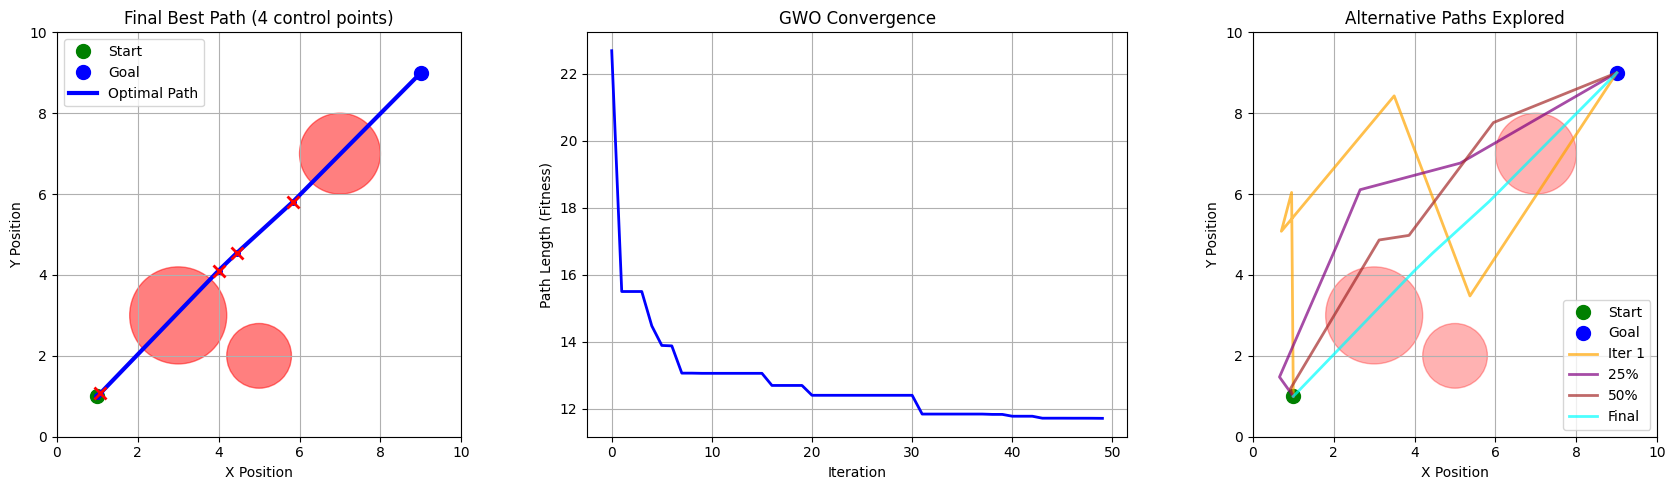

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_user_input():
    """Get environment parameters from user"""
    print("=== Robot Path Planning Configuration ===")

    # Get start point
    print("\nEnter START point:")
    start_x = float(input("Start X coordinate (0-10): "))
    start_y = float(input("Start Y coordinate (0-10): "))
    start_point = (start_x, start_y)

    # Get goal point
    print("\nEnter GOAL point:")
    goal_x = float(input("Goal X coordinate (0-10): "))
    goal_y = float(input("Goal Y coordinate (0-10): "))
    goal_point = (goal_x, goal_y)

    # Get obstacles
    obstacles = []
    print("\nEnter OBSTACLES (circular obstacles as x,y,radius):")
    num_obstacles = int(input("How many obstacles? "))

    for i in range(num_obstacles):
        print(f"\nObstacle {i+1}:")
        obs_x = float(input(f"  X coordinate (0-10): "))
        obs_y = float(input(f"  Y coordinate (0-10): "))
        obs_radius = float(input(f"  Radius (0.5-2): "))
        obstacles.append((obs_x, obs_y, obs_radius))

    # Get GWO parameters
    print("\nEnter GWO parameters:")
    num_wolves = int(input("Number of wolves (5-30): "))
    max_iter = int(input("Maximum iterations (10-100): "))

    # NEW: Get number of control points
    num_control_points = int(input("Number of control points (2-5, more = more flexible paths): "))

    return start_point, goal_point, obstacles, num_wolves, max_iter, num_control_points

def generate_path(start, goal, control_points):
    """Generate a smooth path using control points"""
    path = [start]
    # Add control points
    for point in control_points:
        path.append(point)
    path.append(goal)
    return path

def path_fitness(control_points, start, goal, obstacles):
    """Calculate fitness of a path (lower is better)"""
    path = generate_path(start, goal, control_points)

    # Penalty for collision
    if check_collision(path, obstacles):
        return 1000  # Very high penalty

    # Calculate path length (we want to minimize this)
    length = calculate_path_length(path)

    # Small penalty for number of control points (simpler paths are better)
    complexity_penalty = len(control_points) * 0.1

    return length + complexity_penalty

def gwo_path_planning_flexible(start, goal, obstacles, num_wolves=15, max_iter=50, num_control_points=3):
    """GWO for robot path planning with flexible control points"""
    # Each wolf has: [x1,y1, x2,y2, x3,y3, ...] based on num_control_points
    dimensions = 2 * num_control_points  # Each control point has x and y
    search_space = np.array([[0, 10]] * dimensions)  # 10x10 map

    # Initialize wolves (control points)
    wolves = np.random.uniform(0, 10, (num_wolves, dimensions))

    # Initialize best wolves
    alpha = wolves[0].copy()
    beta = wolves[1].copy()
    delta = wolves[2].copy()

    alpha_score = float('inf')
    beta_score = float('inf')
    delta_score = float('inf')

    convergence = []
    all_best_paths = []  # Store best path from each iteration

    print(f"\nStarting GWO with {num_control_points} control points...")

    for iteration in range(max_iter):
        for i in range(num_wolves):
            # Convert wolf position to control points
            control_points = []
            for j in range(num_control_points):
                x = wolves[i][2*j]
                y = wolves[i][2*j + 1]
                control_points.append((x, y))

            # Calculate fitness
            fitness = path_fitness(control_points, start, goal, obstacles)

            # Update best wolves
            if fitness < alpha_score:
                alpha_score, beta_score, delta_score = fitness, alpha_score, beta_score
                alpha, beta, delta = wolves[i].copy(), alpha.copy(), beta.copy()
            elif fitness < beta_score:
                beta_score, delta_score = fitness, beta_score
                beta, delta = wolves[i].copy(), beta.copy()
            elif fitness < delta_score:
                delta_score = fitness
                delta = wolves[i].copy()

        # Store the best path of this iteration
        best_control_points = []
        for j in range(num_control_points):
            x = alpha[2*j]
            y = alpha[2*j + 1]
            best_control_points.append((x, y))
        all_best_paths.append(best_control_points)

        # Update positions
        a = 2 - iteration * (2 / max_iter)

        for i in range(num_wolves):
            for j in range(dimensions):
                r1, r2 = np.random.random(), np.random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha[j] - wolves[i][j])
                X1 = alpha[j] - A1 * D_alpha

                r1, r2 = np.random.random(), np.random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_beta = abs(C2 * beta[j] - wolves[i][j])
                X2 = beta[j] - A2 * D_beta

                r1, r2 = np.random.random(), np.random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_delta = abs(C3 * delta[j] - wolves[i][j])
                X3 = delta[j] - A3 * D_delta

                wolves[i][j] = (X1 + X2 + X3) / 3

            # Keep within bounds
            wolves[i] = np.clip(wolves[i], search_space[:, 0], search_space[:, 1])

        convergence.append(alpha_score)
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}, Best Path Length: {alpha_score:.2f}")

    return alpha, alpha_score, convergence, all_best_paths

def plot_multiple_paths(start, goal, obstacles, best_solution, convergence, all_best_paths, num_control_points):
    """Plot the environment, best path, convergence, and alternative paths"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Final Best Path
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_aspect('equal')

    # Plot obstacles
    for ox, oy, radius in obstacles:
        circle = plt.Circle((ox, oy), radius, color='red', alpha=0.5)
        ax1.add_patch(circle)

    # Plot start and goal
    ax1.plot(start[0], start[1], 'go', markersize=10, label='Start')
    ax1.plot(goal[0], goal[1], 'bo', markersize=10, label='Goal')

    # Plot final best path
    control_points = []
    for j in range(num_control_points):
        x = best_solution[2*j]
        y = best_solution[2*j + 1]
        control_points.append((x, y))

    best_path = generate_path(start, goal, control_points)
    path_x = [point[0] for point in best_path]
    path_y = [point[1] for point in best_path]
    ax1.plot(path_x, path_y, 'b-', linewidth=3, label='Optimal Path')
    ax1.plot(path_x, path_y, 'bo', markersize=4)

    # Plot control points
    for cp in control_points:
        ax1.plot(cp[0], cp[1], 'rx', markersize=8, markeredgewidth=2)

    ax1.set_title(f'Final Best Path ({num_control_points} control points)')
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Convergence
    ax2.plot(convergence, 'b-', linewidth=2)
    ax2.set_title('GWO Convergence')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Path Length (Fitness)')
    ax2.grid(True)

    # Plot 3: Alternative Paths from different iterations
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)
    ax3.set_aspect('equal')

    # Plot obstacles
    for ox, oy, radius in obstacles:
        circle = plt.Circle((ox, oy), radius, color='red', alpha=0.3)
        ax3.add_patch(circle)

    # Plot start and goal
    ax3.plot(start[0], start[1], 'go', markersize=10, label='Start')
    ax3.plot(goal[0], goal[1], 'bo', markersize=10, label='Goal')

    # Plot several alternative paths from different iterations
    iterations_to_plot = [0, len(all_best_paths)//4, len(all_best_paths)//2, len(all_best_paths)-1]
    colors = ['orange', 'purple', 'brown', 'cyan']
    labels = ['Iter 1', '25%', '50%', 'Final']

    for idx, iter_num in enumerate(iterations_to_plot):
        if iter_num < len(all_best_paths):
            alt_path = generate_path(start, goal, all_best_paths[iter_num])
            path_x = [point[0] for point in alt_path]
            path_y = [point[1] for point in alt_path]
            ax3.plot(path_x, path_y, color=colors[idx], linewidth=2, label=labels[idx], alpha=0.7)

    ax3.set_title('Alternative Paths Explored')
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.legend()
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # Get user input
    start, goal, obstacles, num_wolves, max_iter, num_control_points = get_user_input()

    print("\nEnvironment Created:")
    print(f"Start: {start}")
    print(f"Goal: {goal}")
    print(f"Obstacles: {obstacles}")
    print(f"GWO Parameters: {num_wolves} wolves, {max_iter} iterations, {num_control_points} control points")

    # Run GWO optimization
    best_solution, best_score, convergence, all_best_paths = gwo_path_planning_flexible(
        start, goal, obstacles, num_wolves, max_iter, num_control_points
    )

    print(f"\nOptimization Complete!")
    print(f"Best Path Length: {best_score:.2f}")

    # Display results
    plot_multiple_paths(start, goal, obstacles, best_solution, convergence, all_best_paths, num_control_points)